In [1]:
import torch
from torch.utils.data import DataLoader

from model.encoder import Encoder
from model.decoder import Decoder
from datautil.waymo_dataset import WaymoDataset
from datautil.waymo_rast_dataset import waymo_raster_collate_fn

dataset = WaymoDataset('./data/tfrecords', './data/idxs')
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_raster_collate_fn(x))

data0 = next(iter(dataloader))

In [2]:
scene_img_batch, tgt_img_batch, agent_points_batch, states_feat_batch, agents_batch_mask, \
                states_padding_mask_batch, (states_hidden_mask_BP_batch,states_hidden_mask_CBP_batch,states_hidden_mask_GDP_batch) = data0

In [3]:
print(scene_img_batch.shape)
message = 'scene img : [6,500,500]. \n6-channel image input : \n\t 0: drivable area \n\t 1: centerline \n\t 2: road lane \n\t 3: red lights \
\n\t 4: yellow lights \n\t 5: green lights'
print(message)
print('')
print(tgt_img_batch.shape)
message = 'tgt_img : [num_agents,500,500]. \noccupied map img with line width 1'
print(message)
print('')
print(agent_points_batch.shape)
message = 'agent points : [num_agents,4]. \neach agent\'s start(current) point and end point \nstart_x, start_y, end_x, end_y'
print(message)
print('')
print(states_feat_batch.shape)
message = 'states feat : [num_agent,time_steps,9]. \number of ntime steps is 91. \n9-channel input: \n\t (x,y,bbox_yaw,vel_x,vel_y,vel_yaw,width,length,timestamp)'
print(message)
print('')
print(agents_batch_mask.shape)
message = 'agents batch mask : [num_agent,num_agent]. \nagent-to-agent mask. If two agents are from different scenes, it is False, else, True'
print(message)
print('')
print(states_padding_mask_batch.shape)
message = 'state padding mask : [num_agent,time_steps]. \nif state value is invalid in specific time step, it is False, else, True'
print(message)
print('')
print(states_hidden_mask_BP_batch.shape)
message = 'states hidden mask : [num_agent,time_steps]. \nfollowing scene transformer, True mean that value is masked to be inferred'
print(message)

(6, 500, 500)
scene img : [6,500,500]. 
6-channel image input : 
	 0: drivable area 
	 1: centerline 
	 2: road lane 
	 3: red lights 
	 4: yellow lights 
	 5: green lights

(78, 500, 500)
tgt_img : [num_agents,500,500]. 
occupied map img with line width 1

(78, 4)
agent points : [num_agents,4]. 
each agent's start(current) point and end point 
start_x, start_y, end_x, end_y

(78, 91, 9)
states feat : [num_agent,time_steps,9]. 
umber of ntime steps is 91. 
9-channel input: 
	 (x,y,bbox_yaw,vel_x,vel_y,vel_yaw,width,length,timestamp)

(78, 78)
agents batch mask : [num_agent,num_agent]. 
agent-to-agent mask. If two agents are from different scenes, it is False, else, True

(78, 91)
state padding mask : [num_agent,time_steps]. 
if state value is invalid in specific time step, it is False, else, True

(78, 91)
states hidden mask : [num_agent,time_steps]. 
following scene transformer, True mean that value is masked to be inferred


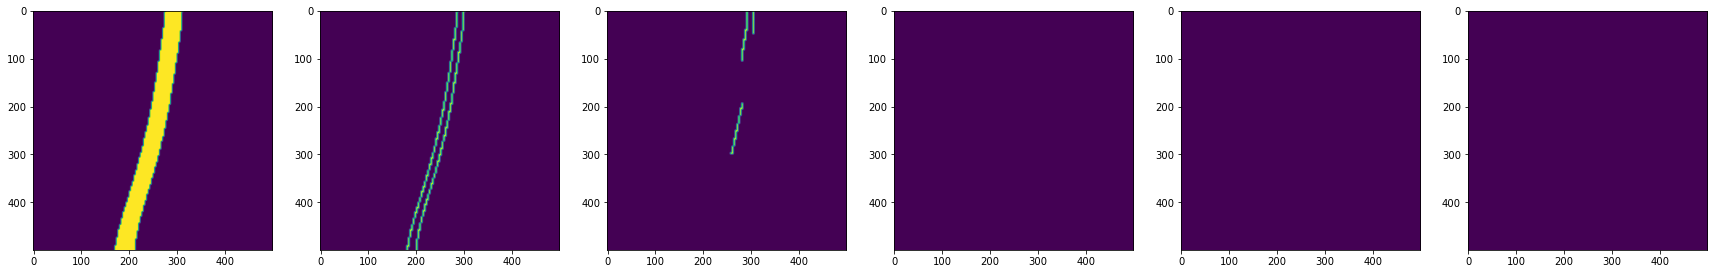

In [50]:
import matplotlib.pyplot as plt


n = scene_img_batch.shape[0]
plt.figure(figsize=(5*n,5))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(scene_img_batch[i])
plt.show()

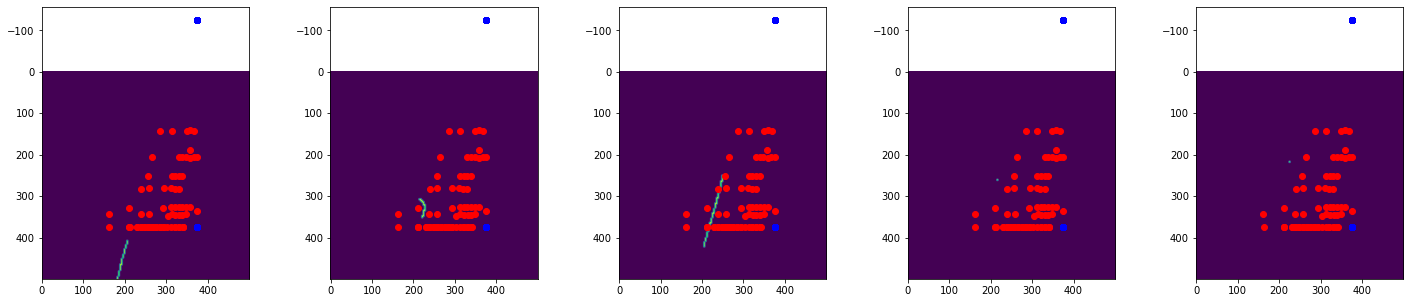

In [74]:
import matplotlib.pyplot as plt
import numpy as np

width = 150
agent_points_batch = np.clip(agent_points_batch, -1, 1)
agent_points_batch_ = (agent_points_batch+0.5)*250

n = min(tgt_img_batch.shape[0], 5)
plt.figure(figsize=(5*n,5))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(tgt_img_batch[i])
    
    plt.scatter(agent_points_batch_[:, 0], agent_points_batch_[:, 1], c='r')
    plt.scatter(agent_points_batch_[:, 2], agent_points_batch_[:, 3], c='b')
    # plt.xlim([-w/2, w/2])
    # plt.ylim([-h/2, h/2])
plt.show()

In [71]:
agent_points_batch[:, 0]*250

array([205.90779622, 216.35375977, 250.        , 214.52555339,
       223.49100749, 213.94063314, 214.64477539, 232.92012533,
       250.        , 205.82478841, 204.94873047, 195.70495605,
       223.55794271, 213.85274251, 197.06624349, 195.89396159,
       204.68811035, 188.31665039, 187.28474935, 196.14786784,
       178.34065755, 177.91809082, 187.54089355, 168.29264323,
       168.2228597 , 159.16890462, 205.20528158, 150.29642741,
       195.06225586, 141.43188477, 186.00036621, 132.57202148,
       131.86299642, 168.72009277, 214.17195638, 122.15535482,
       205.03499349, 141.49881999, 196.26505534, 187.78218587,
       113.76057943, 113.75854492, 131.45996094, 104.96419271,
       132.36755371, 141.0337321 , 114.40836589, 132.37243652,
       114.20979818, 242.33398438, 233.36649577, 250.        ,
        85.97045898, 130.98714193, 223.20414225, 213.92171224,
       204.96073405, 113.5530599 , 168.89363607,  85.79874674,
       158.98213704, 150.15380859, 232.56327311, 141.88

In [81]:
scene_img_batch.max()

1.0

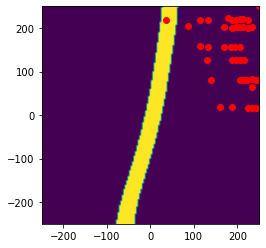

In [53]:
n, h, w = scene_img_batch.shape[:3]
plt.imshow(scene_img_batch[0], extent=[-h/2, h/2, -w/2, w/2])
plt.scatter(agent_points_batch[:, 0]*(w/2), agent_points_batch[:, 1]*(h/2), c='r')
plt.scatter(agent_points_batch[:, 2]*(w/2), agent_points_batch[:, 3]*(h/2), c='b')
plt.xlim([-w/2, w/2])
plt.ylim([-h/2, h/2])
plt.show()


In [30]:
agent_points_batch

array([[ 8.23631185e-01,  1.63217122e+00,  5.02913818e+01,
         1.87496338e+02],
       [ 8.65415039e-01,  1.23578125e+00,  6.68108521e+01,
         1.05297363e+02],
       [ 1.00000000e+00,  1.00000000e+00,  6.11754761e+01,
         1.26084473e+02],
       [ 8.58102214e-01,  1.05296875e+00,  1.06111694e+03,
        -2.03047241e+03],
       [ 8.93964030e-01,  8.72272135e-01,  1.06111694e+03,
        -2.03047241e+03],
       [ 8.55762533e-01,  8.84257813e-01,  1.06111694e+03,
        -2.03047241e+03],
       [ 8.58579102e-01,  1.12117187e+00,  6.43934326e+01,
         8.40878906e+01],
       [ 9.31680501e-01,  8.07639974e-01,  1.06111694e+03,
        -2.03047241e+03],
       [ 1.13571859e+00,  8.46982422e-01,  8.51788940e+01,
         6.35236816e+01],
       [ 8.23299154e-01,  8.80579427e-01,  1.06111694e+03,
        -2.03047241e+03],
       [ 8.19794922e-01,  1.12519857e+00,  6.14846191e+01,
         8.43898926e+01],
       [ 7.82819824e-01,  1.05282227e+00,  5.87114868e+01,
      